In [ ]:
!nvidia-smi

Sun Apr 11 07:53:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install  tensorflow-gpu
!pip install scipy
!pip install simpleitk
!pip install grpcio
!pip install git+https://github.com/aleju/imgaug.git

In [ ]:
%matplotlib inline
import nibabel as nib
import tensorflow as tf
import datetime
import tensorflow as tf
print(tf.__version__)
import numpy as np
import h5py
import os
import random
from sklearn.utils import shuffle
from tqdm import tqdm
import math
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
import glob  # For populating the list of files
import re  # For parsing the filenames (to know their modality)
from skimage.transform import resize # For resizing
from scipy.ndimage import zoom  # For resizing but not used for now
import matplotlib.pyplot as plt
from PIL import Image
import imgaug.augmenters as iaa
from sklearn.model_selection import KFold


2.4.1


In [ ]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))
  
def itensity_normalize_one_volume(volume):
    """
    normalize the itensity of an nd volume based on the mean and std of nonzeor region.
    inputs:
        volume: the input nd volume.
    outputs:
        out: the normalized nd volume.
    """
    pixels = volume[volume > 0]
    mean = pixels.mean()
    std  = pixels.std()
    out  = (volume - mean)/std
    out_random = np.zeros(volume.shape)
    out[volume == 0] = out_random[volume == 0]
    return out
  
def get_none_zero_region(im, margin):
    """
    get the bounding box of the non-zero region of an ND volume.
    """
    input_shape = im.shape
    if(type(margin) is int ):
        margin = [margin]*len(input_shape)
    assert(len(input_shape) == len(margin))
    indxes = np.nonzero(im)
    idx_min = []
    idx_max = []
    for i in range(len(input_shape)):
        idx_min.append(indxes[i].min())
        idx_max.append(indxes[i].max())

    for i in range(len(input_shape)):
        idx_min[i] = max(idx_min[i] - margin[i], 0)
        idx_max[i] = min(idx_max[i] + margin[i], input_shape[i] - 1)
    return idx_min, idx_max
  
def crop_ND_volume_with_bounding_box(volume, min_idx, max_idx):
    """
    crop/extract a subregion form an nd image.
    """
    dim = len(volume.shape)
    assert(dim >= 2 and dim <= 5)
    if(dim == 2):
      output = volume[np.ix_(range(min_idx[0], max_idx[0] + 1),
                               range(min_idx[1], max_idx[1] + 1))]
    elif(dim == 3):
        output = volume[np.ix_(range(min_idx[0], max_idx[0] + 1),
                               range(min_idx[1], max_idx[1] + 1),
                               range(min_idx[2], max_idx[2] + 1))]
    elif(dim == 4):
        output = volume[np.ix_(range(min_idx[0], max_idx[0] + 1),
                               range(min_idx[1], max_idx[1] + 1),
                               range(min_idx[2], max_idx[2] + 1),
                               range(min_idx[3], max_idx[3] + 1))]
    elif(dim == 5):
        output = volume[np.ix_(range(min_idx[0], max_idx[0] + 1),
                               range(min_idx[1], max_idx[1] + 1),
                               range(min_idx[2], max_idx[2] + 1),
                               range(min_idx[3], max_idx[3] + 1),
                               range(min_idx[4], max_idx[4] + 1))]
    else:
        raise ValueError("the dimension number shoud be 2 to 5")
    return output

def my_resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)

def get_random_roi_sampling_center(input_shape, output_shape, sample_mode='full', bounding_box = None):
    """
    get a random coordinate representing the center of a roi for sampling
    inputs:
        input_shape: the shape of sampled volume
        output_shape: the desired roi shape
        sample_mode: 'valid': the entire roi should be inside the input volume
                     'full': only the roi centre should be inside the input volume
        bounding_box: the bounding box which the roi center should be limited to
    outputs:
        center: the output center coordinate of a roi
    """
    center = []
    for i in range(len(input_shape)):
        if(sample_mode[i] == 'full'):
            if(bounding_box):
                x0 = bounding_box[i*2]; x1 = bounding_box[i*2 + 1]
            else:
                x0 = 0; x1 = input_shape[i]
        else:
            if(bounding_box):
                x0 = bounding_box[i*2] + int(output_shape[i]/2)   
                x1 = bounding_box[i*2+1] - int(output_shape[i]/2)   
            else:
                x0 = int(output_shape[i]/2)   
                x1 = input_shape[i] - x0
        if(x1 <= x0):
            centeri = int((x0 + x1)/2)
        else:
            centeri = np.random.randint(x0, x1)
        center.append(centeri)
    return center
def extract_roi_from_volume(volume, in_center, output_shape, fill = 'random'):
    """
    extract a roi from a 3d volume
    inputs:
        volume: the input 3D volume
        in_center: the center of the roi
        output_shape: the size of the roi
        fill: 'random' or 'zero', the mode to fill roi region where is outside of the input volume
    outputs:
        output: the roi volume
    """
    input_shape = volume.shape   
    if(fill == 'random'):
        output = np.random.normal(0, 1, size = output_shape)
    else:
        output = np.zeros(output_shape)
    r0max = [int(x/2) for x in output_shape]
    r1max = [output_shape[i] - r0max[i] for i in range(len(r0max))]
    r0 = [min(r0max[i], in_center[i]) for i in range(len(r0max))]
    r1 = [min(r1max[i], input_shape[i] - in_center[i]) for i in range(len(r0max))]
    out_center = r0max

    output[np.ix_(range(out_center[0] - r0[0], out_center[0] + r1[0]),
                  range(out_center[1] - r0[1], out_center[1] + r1[1]),
                  range(out_center[2] - r0[2], out_center[2] + r1[2]))] = \
        volume[np.ix_(range(in_center[0] - r0[0], in_center[0] + r1[0]),
                      range(in_center[1] - r0[1], in_center[1] + r1[1]),
                      range(in_center[2] - r0[2], in_center[2] + r1[2]))]
    return output

def zero_padding_3d(volume,size=((29, 30),(11,12),(29,30))):
    x= np.pad(volume,pad_width=size,mode='constant', constant_values=0)
    return x  

def preprocess_label(img):

    """
    pad
    """
    # img = zero_padding_3d(img)
        
    """
    Separates out the 1 labels from the segmentation
    """
    ms_plk = img == 1
        
    return np.array([ms_plk], dtype=np.uint8)

In [ ]:
# Get a list of files for all modalities individually for train
mprage = glob.glob('/gdrive/My Drive/main dataset ISBI 2015/training_final_v4/training/*/preprocessed/*mprage_pp.nii')
mprage.sort()
T2 = glob.glob('/gdrive/My Drive/main dataset ISBI 2015/training_final_v4/training/*/preprocessed/*t2_pp.nii')
T2.sort()
FLAIR= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/training_final_v4/training/*/preprocessed/*flair_pp.nii')
FLAIR.sort()
PD= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/training_final_v4/training/*/preprocessed/*pd_pp.nii')
PD.sort()
mask_1= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/training_final_v4/training/*/masks/*mask1_pp.nii')  # Ground Truth rater1
mask_1.sort()
mask_2= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/training_final_v4/training/*/masks/*mask2_pp.nii')  # Ground Truth rater2
mask_2.sort()

In [ ]:
print(np.shape(mprage))
print(np.shape(T2))
print(np.shape(FLAIR))
print(np.shape(PD))
print(np.shape(mask_1))
print(np.shape(mask_2))
print(mprage)
print(T2)
print(FLAIR)
print(PD)
print(mask_1)
print(mask_2)

In [ ]:
# Get a list of files for all modalities individually or test
Test_mprage = glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*mprage_pp.nii')
Test_mprage.sort()
Test_T2 = glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*t2_pp.nii')
Test_T2.sort()
Test_FLAIR= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*flair_pp.nii')
Test_FLAIR.sort()
Test_PD= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*pd_pp.nii')
Test_PD.sort()

In [ ]:
print(np.shape(Test_mprage))
print(np.shape(Test_T2))
print(np.shape(Test_FLAIR))
print(np.shape(Test_PD))
print(Test_mprage)
print(Test_T2)
print(Test_FLAIR)
print(Test_PD)

In [ ]:
"""
Parse all the training filenames and create a dictionary for each patient with structure:
"""
pat = re.compile('.*_(\w*)\_pp\.nii')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(mprage, FLAIR, T2, PD, mask_1, mask_2))]
print(data_paths)
print(type(data_paths))
print(np.shape(data_paths))

In [ ]:
n_d = 21
input_shape= (2,240,240)
input_shape_data = (2,181,240,240)
output_channels = 1
dataa = np.empty((1392,) + input_shape, dtype=np.float32)
labels = np.empty((1392, output_channels) + input_shape[1:], dtype=np.float32)

print(type(input_shape))
print(np.shape(dataa))
print(type(dataa))
print(np.shape(labels))
print(type((len(data_paths[:n_d]),)))
print(type(labels))
print(type(data_paths))

In [ ]:
# Parameters for the progress bar
total = len(data_paths[:n_d])
step = 25 / total
k = 0
count = 0
m = 0
counting = 0
z=0
for i, imgs in enumerate(data_paths[:n_d]):
    try:
        data=np.empty((1,) + input_shape_data, dtype=np.float32)
        label=np.empty((1, output_channels) + input_shape_data[1:], dtype=np.float32)
        data[0]= np.array([preprocess(read_img(imgs[m])) for m in ['flair','mprage']], dtype=np.float32)
        label[0]= preprocess_label(read_img(imgs['mask1']))[None, ...]
        for j in range(181):
            if not np.all(label[0][:,j,:,:] == np.zeros((1,240,240))):
               dataa[k]= data[0][:,j,:,:]
               labels[k]= label[0][:,j,:,:]
               k+=1   
        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["T1"]}, skipping...\n Exception:\n{str(e)}')
        continue
data=np.empty((1,) + input_shape_data, dtype=np.float32)
label=np.empty((1, output_channels) + input_shape_data[1:], dtype=np.uint8)   


In [ ]:
dataaa = np.einsum('iCHW->iHWC', dataa)
labelss = np.einsum('iCHW->iHWC', labels)
print(np.shape(dataaa))
print(np.shape(labelss))


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(dataaa,labelss,test_size=0.2,random_state=73)
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_val))
print(np.shape(y_val))

In [ ]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10.125,6.75))
index =600
ax1.imshow(x_train[index,:,:,1], cmap='gray')
ax2.imshow(y_train[index,:,:,0], cmap='gray')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10.125,6.75))
index =200
ax1.imshow(x_val[index,:,:,1], cmap='gray')
ax2.imshow(y_val[index,:,:,0], cmap='gray')

In [ ]:
hf = h5py.File("/gdrive/My Drive/data_train_ISBI_just_ms_slice.hdf5", "w")
dset = hf.create_dataset("data_train_ISBI_just_ms_slice", data=x_train)
hf.close()

In [ ]:
hf = h5py.File("/gdrive/My Drive/label_train_ISBI_just_ms_slice.hdf5", "w")
dset = hf.create_dataset("label_train_ISBI_just_ms_slice", data=y_train)
hf.close()

In [ ]:
hf = h5py.File("/gdrive/My Drive/data_val_ISBI_just_ms_slice.hdf5", "w")
dset = hf.create_dataset("data_val_ISBI_just_ms_slice", data=x_val)
hf.close()

In [ ]:
hf = h5py.File("/gdrive/My Drive/label_val_ISBI_just_ms_slice.hdf5", "w")
dset = hf.create_dataset("label_val_ISBI_just_ms_slice", data=y_val)
hf.close()

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_just_ms_slice.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_just_ms_slice.hdf5', 'r')
        data_len = hf_x['data_train_just_ms_slice'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    for w in [0,1]:
                        norm_modal= itensity_normalize_one_volume(hf_x['data_train_just_ms_slice'][i,:,:,w])
                        norm_input.append(norm_modal)
                    norm_input = np.einsum('CHW->HWC', norm_input)
                    data_x.append(norm_input)
                    data_y.append(hf_y['label_train_just_ms_slice'][i, :])
                    # gt_train = [np.array(data_y),np.array(data_y)]
                yield(np.array(data_x),np.array(data_y))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def valset_generator(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_val_just_ms_slice.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_val_just_ms_slice.hdf5', 'r')
        data_len = hf_x['data_val_just_ms_slice'].shape[0]
        while True:
            index = list(range(data_len))
            for x in batch(index, batch_size):
                data_x_val=[]
                data_y_val=[]
                for i in x:
                    norm_input_val=[]
                    for w in [0,1]:
                        norm_modal_val= itensity_normalize_one_volume(hf_x['data_val_just_ms_slice'][i,:,:,w])
                        norm_input_val.append(norm_modal_val)
                    norm_input_val = np.einsum('CHW->HWC', norm_input_val)
                    data_x_val.append(norm_input_val)
                    data_y_val.append(hf_y['label_val_just_ms_slice'][i, :])
                    # gt_val = [np.array(data_y_val),np.array(data_y_val)]
                yield(np.array(data_x_val),np.array(data_y_val))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]

seq = iaa.Sequential([iaa.Fliplr(0.5),
                      iaa.Flipud(0.5)
                      # sometimes2(iaa.Rot90(1,True))
                ])
def trainset_generator_augmentation(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_ISBI_just_ms_slice.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_ISBI_just_ms_slice.hdf5', 'r')
        data_len = hf_x['data_train_ISBI_just_ms_slice'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    for w in [0,1]:
                        norm_modal= itensity_normalize_one_volume(hf_x['data_train_ISBI_just_ms_slice'][i,:,:,w])
                        norm_input.append(norm_modal)
                    norm_input = np.einsum('CHW->HWC', norm_input)
                    data_x.append(norm_input)
                    data_y.append(hf_y['label_train_ISBI_just_ms_slice'][i, :])
                images_for_aug = np.array(data_x)
                labels_for_aug= np.array(data_y).astype(np.int32)
                images_aug, segmaps_aug = seq(images=images_for_aug, segmentation_maps=labels_for_aug)
                yield(images_aug,segmaps_aug.astype(np.float32))

In [ ]:
#####for testing train generator 3D ISBI
%matplotlib inline
hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
data_x=[]
data_y=[]
data_y1=[]
data_y2=[]
for i in range(0,3):
    norm_input=[]
    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
    croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
    roi_sampled= get_random_roi_sampling_center(np.shape(croped_zero), (128,128,128), sample_mode='valid',bounding_box=None)
    for w in [0,1,2,3]:
        croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,w], idx_min,idx_max)
        extracted_roi=extract_roi_from_volume(croped_zero,roi_sampled, (128,128,128), fill = 'zero')
        norm_modal=itensity_normalize_one_volume(extracted_roi)
        norm_input.append(norm_modal)   
    norm_input = np.einsum('CDHW->HWDC', norm_input)
    croped_mask1=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
    extract_roi_mask1= extract_roi_from_volume(croped_mask1,roi_sampled, (128,128,128), fill = 'zero')
    croped_mask2=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,1], idx_min,idx_max)
    extract_roi_mask2= extract_roi_from_volume(croped_mask2,roi_sampled, (128,128,128), fill = 'zero')
    extract_roi_mask= extract_roi_mask1 + extract_roi_mask2
    extract_roi_mask[extract_roi_mask<=1]=0
    extract_roi_mask[extract_roi_mask>1]= 1
    extract_roi_mask= np.expand_dims(extract_roi_mask,axis=0)
    extract_roi_mask= np.einsum('CDHW->HWDC', extract_roi_mask)
    extract_roi_mask1= np.expand_dims(extract_roi_mask1,axis=0)
    extract_roi_mask1= np.einsum('CDHW->HWDC', extract_roi_mask1)
    extract_roi_mask2= np.expand_dims(extract_roi_mask2,axis=0)
    extract_roi_mask2= np.einsum('CDHW->HWDC', extract_roi_mask2)
    data_x.append(norm_input)
    data_y.append(extract_roi_mask)
    data_y1.append(extract_roi_mask1)
    data_y2.append(extract_roi_mask2)

(3, 128, 128, 128, 4)


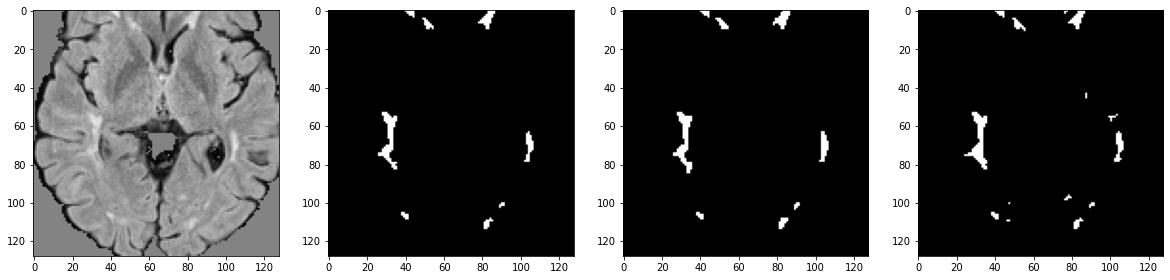

In [ ]:
print(np.shape(data_x))
fig, (ax1, ax2, ax3, ax4)= plt.subplots(1,4,figsize=(2*10.125,2*6.75))
u=64
ax1.imshow(np.array(data_x)[2,:,:,u,0], cmap='gray')
ax2.imshow(np.array(data_y)[2,:,:,u,0], cmap='gray')
ax3.imshow(np.array(data_y1)[2,:,:,u,0], cmap='gray')
ax4.imshow(np.array(data_y2)[2,:,:,u,0], cmap='gray')

In [ ]:

def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
                    croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    roi_sampled= get_random_roi_sampling_center(np.shape(croped_zero), (128,128,128), sample_mode='valid',bounding_box=None)
                    for w in range(0,4):
                        croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,w], idx_min,idx_max)
                        extracted_roi=extract_roi_from_volume(croped_zero,roi_sampled, (128,128,128), fill = 'zero')
                        norm_modal=itensity_normalize_one_volume(extracted_roi)
                        norm_input.append(norm_modal)   
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    croped=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    extract_roi_mask= extract_roi_from_volume(croped,roi_sampled, (128,128,128), fill = 'zero')
                    extract_roi_mask= np.expand_dims(extract_roi_mask,axis=0)
                    extract_roi_mask= np.einsum('CDHW->HWDC', extract_roi_mask)
                    data_x.append(norm_input)
                    data_y.append(extract_roi_mask)
                    # gt_train = [np.array(data_y),np.array(data_y),np.array(data_y),np.array(data_y)]
                yield(np.array(data_x),np.array(data_y))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI_maj(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
                    croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    roi_sampled= get_random_roi_sampling_center(np.shape(croped_zero), (128,128,128), sample_mode='valid',bounding_box=None)
                    for w in range(0,4):
                        croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,w], idx_min,idx_max)
                        extracted_roi=extract_roi_from_volume(croped_zero,roi_sampled, (128,128,128), fill = 'zero')
                        norm_modal=itensity_normalize_one_volume(extracted_roi)
                        norm_input.append(norm_modal)   
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    croped_mask1=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    extract_roi_mask1= extract_roi_from_volume(croped_mask1,roi_sampled, (128,128,128), fill = 'zero')
                    croped_mask2=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,1], idx_min,idx_max)
                    extract_roi_mask2= extract_roi_from_volume(croped_mask2,roi_sampled, (128,128,128), fill = 'zero')
                    extract_roi_mask= extract_roi_mask1 + extract_roi_mask2
                    extract_roi_mask[extract_roi_mask<=1]=0
                    extract_roi_mask[extract_roi_mask>1]= 1
                    extract_roi_mask= np.expand_dims(extract_roi_mask,axis=0)
                    extract_roi_mask= np.einsum('CDHW->HWDC', extract_roi_mask)
                    data_x.append(norm_input)
                    data_y.append(extract_roi_mask)
                    # gt_train = [np.array(data_y),np.array(data_y),np.array(data_y),np.array(data_y)]
                yield(np.array(data_x),np.array(data_y))

false
here2
false
here2
true
here1
true
here1
true
here1
true
here1


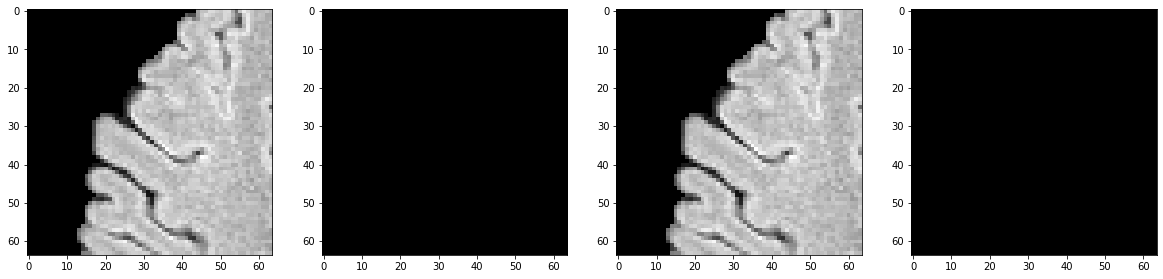

In [ ]:
#####for extract train patch 3D ISBI
%matplotlib inline
def crop_ND_volume_with_bounding_box(volume, min_idx, max_idx):
    """
    crop/extract a subregion form an nd image.
    """
    dim = len(volume.shape)
    channel_dim = volume.shape[-1]
    output = volume[np.ix_(range(min_idx[0], max_idx[0] + 1),
                           range(min_idx[1], max_idx[1] + 1),
                           range(min_idx[2], max_idx[2] + 1),
                           range(channel_dim))]
    return output
def get_random_roi_sampling_center(input_shape, output_shape, sample_mode='full', bounding_box = None):
    """
    get a random coordinate representing the center of a roi for sampling
    inputs:
        input_shape: the shape of sampled volume
        output_shape: the desired roi shape
        sample_mode: 'valid': the entire roi should be inside the input volume
                     'full': only the roi centre should be inside the input volume
        bounding_box: the bounding box which the roi center should be limited to
    outputs:
        center: the output center coordinate of a roi
    """
    center = []
    for i in range(len(input_shape)):
        if(sample_mode == 'full'):
            if(bounding_box):
                x0 = bounding_box[i*2]; x1 = bounding_box[i*2 + 1]
            else:
                x0 = 0; x1 = input_shape[i]
        else:
            if(bounding_box):
                x0 = bounding_box[i*2] + int(output_shape[i]/2)   
                x1 = bounding_box[i*2+1] - int(output_shape[i]/2)   
            else:
                x0 = int(output_shape[i]/2)   
                x1 = input_shape[i] - x0
        if(x1 <= x0):
            centeri = int((x0 + x1)/2)
        else:
            centeri = np.random.randint(x0, x1)
        center.append(centeri)
    return center
def get_random_roi_sampling_center_v2(croped_zero,croped_zero_mask,nonzero_center='true',mask_num=0):
    """
    get a random coordinate representing the center of a roi for sampling
    two option is available:
    1) get roi center that centered on nonzero voxels of mask.
    2) get roi center that centered on nonzero voxels of brain region with a
    margin of border to include more brain region
    mask_num => 0=mask_1   and   1=mask_2
    """
    if nonzero_center=='both':
       nonzero_center = random.choice(['true','false'])
    if nonzero_center=='true':
       mask_nonzero = np.array(croped_zero_mask[:,:,:,mask_num].nonzero())
       random_select = np.random.randint(0,mask_nonzero.shape[1])
       roi_index = mask_nonzero[:,random_select]
    if nonzero_center=='false':
        nonzero = np.array(croped_zero[:,:,:, 0].nonzero())
        random_select = np.random.randint(0,nonzero.shape[1])
        roi_index = nonzero[:,random_select]
    return roi_index
def extract_roi_from_volume(volume, in_center, output_shape, fill = 'random'):
    """
    extract a roi from a 3d volume
    inputs:
        volume: the input 3D volume
        in_center: the center of the roi
        output_shape: the size of the roi
        fill: 'random' or 'zero', the mode to fill roi region where is outside of the input volume
    outputs:
        output: the roi volume
    """
    input_shape = volume.shape   
    if(fill == 'random'):
        output = np.random.normal(0, 1, size = output_shape)
    else:
        output = np.zeros(output_shape)
    r0max = [int(x/2) for x in output_shape]
    r1max = [output_shape[i] - r0max[i] for i in range(len(r0max))]
    r0 = [min(r0max[i], in_center[i]) for i in range(len(r0max))]
    r1 = [min(r1max[i], input_shape[i] - in_center[i]) for i in range(len(r0max))]
    out_center = r0max

    output[np.ix_(range(out_center[0] - r0[0], out_center[0] + r1[0]),
                  range(out_center[1] - r0[1], out_center[1] + r1[1]),
                  range(out_center[2] - r0[2], out_center[2] + r1[2]))] = \
        volume[np.ix_(range(in_center[0] - r0[0], in_center[0] + r1[0]),
                      range(in_center[1] - r0[1], in_center[1] + r1[1]),
                      range(in_center[2] - r0[2], in_center[2] + r1[2]))]
    return output
hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
data_x=[]
data_y=[]
data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
for i in range(2):
    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
    croped_zero = crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,:], idx_min,idx_max) 
    croped_zero_mask =  crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,:], idx_min,idx_max) 
    idx_min_mask, idx_max_mask = get_none_zero_region(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
    for j in range(3):
        # roi_sampled = get_random_roi_sampling_center(np.shape(croped_zero[:,:,:,0]), (64,64,64), sample_mode='full',bounding_box=[idx_min_mask[0],idx_max_mask[0],idx_min_mask[1],idx_max_mask[1],idx_min_mask[2],idx_max_mask[2]])
        roi_sampled = get_random_roi_sampling_center_v2(croped_zero,croped_zero_mask,nonzero_center='both',mask_num=0)
        extracted_roi=[]
        extracted_roi_mask=[]
        for k in range(4):
            extracted_roi.append(extract_roi_from_volume(croped_zero[:,:,:,k],roi_sampled, (64,64,64), fill = 'zero'))
        for kk in range(2):
            extracted_roi_mask.append(extract_roi_from_volume(croped_zero_mask[:,:,:,kk],roi_sampled, (64,64,64), fill = 'zero'))
        extracted_roi = np.einsum('CDHW->DHWC', extracted_roi)
        extracted_roi_mask = np.einsum('CDHW->DHWC', extracted_roi_mask)
        data_x.append(extracted_roi)
        data_y.append(extracted_roi_mask)
fig, (ax1, ax2, ax3, ax4)= plt.subplots(1,4,figsize=(2*10.125,2*6.75))
n=0
u=32
ch=0
ax1.imshow(np.array(data_x)[n,u,:,:,ch], cmap='gray')
ax2.imshow(np.array(data_y)[n,u,:,:,0], cmap='gray')
ax3.imshow(np.array(data_x)[n,u,:,:,ch], cmap='gray')
ax4.imshow(np.array(data_y)[n,u,:,:,1], cmap='gray')

In [ ]:
def crop_ND_volume_with_bounding_box(volume, min_idx, max_idx):
    """
    crop/extract a subregion form an nd image.
    """
    dim = len(volume.shape)
    channel_dim = volume.shape[-1]
    output = volume[np.ix_(range(min_idx[0], max_idx[0] + 1),
                           range(min_idx[1], max_idx[1] + 1),
                           range(min_idx[2], max_idx[2] + 1),
                           range(channel_dim))]
    return output
def get_random_roi_sampling_center_v2(croped_zero,croped_zero_mask,nonzero_center='both',mask_num=1):
    """
    get a random coordinate representing the center of a roi for sampling
    two option is available:
    1) get roi center that centered on nonzero voxels of mask.
    2) get roi center that centered on nonzero voxels of brain region with a
    margin of border to include more brain region
    """
    if nonzero_center=='both':
       nonzero_center = random.choice(['true','false'])
    if nonzero_center=='true':
       mask_nonzero = np.array(croped_zero_mask[:,:,:,mask_num].nonzero())
       random_select = np.random.randint(0,mask_nonzero.shape[1])
       roi_index = mask_nonzero[:,random_select]
    if nonzero_center=='false':
        nonzero = np.array(croped_zero[:,:,:, 0].nonzero())
        random_select = np.random.randint(0,nonzero.shape[1])
        roi_index = nonzero[:,random_select]
    return roi_index
def extract_roi_from_volume(volume, in_center, output_shape, fill = 'random'):
    """
    extract a roi from a 3d volume
    inputs:
        volume: the input 3D volume
        in_center: the center of the roi
        output_shape: the size of the roi
        fill: 'random' or 'zero', the mode to fill roi region where is outside of the input volume
    outputs:
        output: the roi volume
    """
    input_shape = volume.shape   
    if(fill == 'random'):
        output = np.random.normal(0, 1, size = output_shape)
    else:
        output = np.zeros(output_shape)
    r0max = [int(x/2) for x in output_shape]
    r1max = [output_shape[i] - r0max[i] for i in range(len(r0max))]
    r0 = [min(r0max[i], in_center[i]) for i in range(len(r0max))]
    r1 = [min(r1max[i], input_shape[i] - in_center[i]) for i in range(len(r0max))]
    out_center = r0max

    output[np.ix_(range(out_center[0] - r0[0], out_center[0] + r1[0]),
                  range(out_center[1] - r0[1], out_center[1] + r1[1]),
                  range(out_center[2] - r0[2], out_center[2] + r1[2]))] = \
        volume[np.ix_(range(in_center[0] - r0[0], in_center[0] + r1[0]),
                      range(in_center[1] - r0[1], in_center[1] + r1[1]),
                      range(in_center[2] - r0[2], in_center[2] + r1[2]))]
    return output
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI_aug_random_patch_equal_prob(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
                    croped_zero = crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,:], idx_min,idx_max) 
                    croped_zero_mask =  crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,:], idx_min,idx_max)
                    roi_sampled = get_random_roi_sampling_center_v2(croped_zero,croped_zero_mask,nonzero_center='both',mask_num=1)
                    norm_input=[]
                    extracted_roi_mask=[] 
                    for w in range(4):
                        extracted_roi = extract_roi_from_volume(croped_zero[:,:,:,w],roi_sampled, (64,64,64), fill = 'zero')
                        norm_modal = itensity_normalize_one_volume(extracted_roi)
                        norm_input.append(norm_modal)  
                    for ww in range(2):
                        extracted_roi_mask.append(extract_roi_from_volume(croped_zero_mask[:,:,:,ww],roi_sampled, (64,64,64), fill = 'zero'))
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    extract_roi_mask= np.einsum('CDHW->HWDC', extracted_roi_mask)
                    extract_roi_mask= np.expand_dims(extract_roi_mask[:,:,:,1],axis=-1)
                    xy = tf.concat([norm_input, extract_roi_mask], axis=-1)
                    ###fliplr
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[1]),lambda: xy)
                    ###flipud
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[0]),lambda: xy)
                    # ###rot90 counter-clockwise
                    # xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: np.rot90(xy,axes=(0,1)),lambda: xy)
                    # ###rot90 clockwise
                    # xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: np.rot90(xy,axes=(1,0)),lambda: xy)
                    images_aug, segmaps_aug = tf.split(xy, [4, 1], axis=-1)
                    data_x.append(images_aug.numpy())
                    data_y.append(segmaps_aug.numpy())
                yield(np.array(data_x),np.array(data_y))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI_aug(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
                    croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    roi_sampled= get_random_roi_sampling_center(np.shape(croped_zero), (128,128,128), sample_mode='valid',bounding_box=None)
                    for w in range(0,4):
                        croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,w], idx_min,idx_max)
                        extracted_roi=extract_roi_from_volume(croped_zero,roi_sampled, (128,128,128), fill = 'zero')
                        norm_modal=itensity_normalize_one_volume(extracted_roi)
                        norm_input.append(norm_modal)   
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    croped=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,1], idx_min,idx_max)
                    extract_roi_mask= extract_roi_from_volume(croped,roi_sampled, (128,128,128), fill = 'zero')
                    extract_roi_mask= np.expand_dims(extract_roi_mask,axis=0)
                    extract_roi_mask= np.einsum('CDHW->HWDC', extract_roi_mask)
                    xy = tf.concat([norm_input, extract_roi_mask], axis=-1)
                    ###fliplr
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[1]),lambda: xy)
                    ###flipud
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[0]),lambda: xy)
                    images_aug, segmaps_aug = tf.split(xy, [4, 1], axis=-1)
                    data_x.append(images_aug.numpy())
                    data_y.append(segmaps_aug.numpy())
                yield(np.array(data_x),np.array(data_y))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI_aug_patch_wise(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_420patch.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_420patch.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_420patch.hdf5'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    for w in range(0,4):
                        norm_modal=itensity_normalize_one_volume(hf_x['data_train_3D_ISBI_420patch.hdf5'][i,:,:,:,w])
                        norm_input.append(norm_modal)   
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    expanded_mask= np.expand_dims(hf_y['label_train_3D_ISBI_420patch.hdf5'][i,:,:,:,1],axis=0)
                    expanded_mask= np.einsum('CDHW->HWDC', expanded_mask)
                    xy = tf.concat([norm_input, expanded_mask], axis=-1)
                    ###fliplr
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[1]),lambda: xy)
                    ###flipud
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[0]),lambda: xy)
                    # ###rot90 counter-clockwise
                    # xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: np.rot90(xy,axes=(0,1)),lambda: xy)
                    # ###rot90 clockwise
                    # xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: np.rot90(xy,axes=(1,0)),lambda: xy)
                    images_aug, segmaps_aug = tf.split(xy, [4, 1], axis=-1)
                    data_x.append(images_aug.numpy())
                    data_y.append(segmaps_aug.numpy())
                    # gt_train = [np.array(data_y),np.array(data_y),np.array(data_y),np.array(data_y)]
                yield(np.array(data_x),np.array(data_y))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI_maj_aug_kfold(batch_size,num_fold):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
        index = list(range(data_len))
        train_indices=[None]*5
        val_indices=[None]*5
        kf = KFold(n_splits=5,random_state=0,shuffle=True)
        for i, [train_index, val_index] in enumerate(kf.split(index)):
            train_indices[i], val_indices[i] = train_index, val_index
        while True:
            ind = shuffle(train_indices[num_fold])
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
                    croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    roi_sampled= get_random_roi_sampling_center(np.shape(croped_zero), (128,128,128), sample_mode='valid',bounding_box=None)
                    for w in range(0,4):
                        croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,w], idx_min,idx_max)
                        extracted_roi=extract_roi_from_volume(croped_zero,roi_sampled, (128,128,128), fill = 'zero')
                        norm_modal=itensity_normalize_one_volume(extracted_roi)
                        norm_input.append(norm_modal)   
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    croped_mask1=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    extract_roi_mask1= extract_roi_from_volume(croped_mask1,roi_sampled, (128,128,128), fill = 'zero')
                    croped_mask2=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,1], idx_min,idx_max)
                    extract_roi_mask2= extract_roi_from_volume(croped_mask2,roi_sampled, (128,128,128), fill = 'zero')
                    extract_roi_mask= extract_roi_mask1 + extract_roi_mask2
                    extract_roi_mask[extract_roi_mask<=1]=0
                    extract_roi_mask[extract_roi_mask>1]= 1
                    extract_roi_mask= np.expand_dims(extract_roi_mask,axis=0)
                    extract_roi_mask= np.einsum('CDHW->HWDC', extract_roi_mask)
                    xy = tf.concat([norm_input, extract_roi_mask], axis=-1)
                    ###fliplr
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[1]),lambda: xy)
                    ###flipud
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[0]),lambda: xy)
                    images_aug, segmaps_aug = tf.split(xy, [4, 1], axis=-1)
                    data_x.append(images_aug.numpy())
                    data_y.append(segmaps_aug.numpy())
                    # gt_train = [np.array(data_y),np.array(data_y),np.array(data_y),np.array(data_y)]
                yield(np.array(data_x),np.array(data_y))

In [ ]:
def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
               yield iterable[ndx:min(ndx + n, l)]
def trainset_generator_3D_ISBI_maj_aug(batch_size):
        hf_x = h5py.File('/gdrive/My Drive/data_train_3D_ISBI_21sample.hdf5', 'r')
        hf_y = h5py.File('/gdrive/My Drive/label_train_3D_ISBI_21sample.hdf5', 'r')
        data_len = hf_x['data_train_3D_ISBI_21sample.hdf5'].shape[0]
        while True:
            index = list(range(data_len))
            ind = shuffle(index)
            for x in batch(ind, batch_size):
                data_x=[]
                data_y=[]
                for i in x:
                    norm_input=[]
                    idx_min, idx_max=get_none_zero_region(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0],0)
                    croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    roi_sampled= get_random_roi_sampling_center(np.shape(croped_zero), (128,128,128), sample_mode='valid',bounding_box=None)
                    for w in range(0,4):
                        croped_zero=crop_ND_volume_with_bounding_box(hf_x['data_train_3D_ISBI_21sample.hdf5'][i,:,:,:,w], idx_min,idx_max)
                        extracted_roi=extract_roi_from_volume(croped_zero,roi_sampled, (128,128,128), fill = 'zero')
                        norm_modal=itensity_normalize_one_volume(extracted_roi)
                        norm_input.append(norm_modal)   
                    norm_input = np.einsum('CDHW->HWDC', norm_input)
                    croped_mask1=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,0], idx_min,idx_max)
                    extract_roi_mask1= extract_roi_from_volume(croped_mask1,roi_sampled, (128,128,128), fill = 'zero')
                    croped_mask2=crop_ND_volume_with_bounding_box(hf_y['label_train_3D_ISBI_21sample.hdf5'][i,:,:,:,1], idx_min,idx_max)
                    extract_roi_mask2= extract_roi_from_volume(croped_mask2,roi_sampled, (128,128,128), fill = 'zero')
                    extract_roi_mask= extract_roi_mask1 + extract_roi_mask2
                    extract_roi_mask[extract_roi_mask<=0.5]=0
                    extract_roi_mask[extract_roi_mask>0.5]= 1
                    extract_roi_mask= np.expand_dims(extract_roi_mask,axis=0)
                    extract_roi_mask= np.einsum('CDHW->HWDC', extract_roi_mask)
                    xy = tf.concat([norm_input, extract_roi_mask], axis=-1)
                    ###fliplr
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[1]),lambda: xy)
                    ###flipud
                    xy = tf.cond(tf.random.uniform(()) > 0.5,lambda: tf.reverse(xy, axis=[0]),lambda: xy)
                    images_aug, segmaps_aug = tf.split(xy, [4, 1], axis=-1)
                    data_x.append(images_aug.numpy())
                    data_y.append(segmaps_aug.numpy())
                yield(np.array(data_x),np.array(data_y))

In [ ]:
### GroupNormalization code from https://github.com/titu1994/keras-global-context-networks.git repository
from keras.engine import Layer, InputSpec
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K

from keras.utils.generic_utils import get_custom_objects


class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


get_custom_objects().update({'GroupNormalization': GroupNormalization})


if __name__ == '__main__':
    from keras.layers import Input
    from keras.models import Model
    ip = Input(shape=(None, None, 4))
    x = GroupNormalization(groups=2, axis=-1, epsilon=0.1)(ip)
    model = Model(ip, x)
    model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 4)]   0         
_________________________________________________________________
group_normalization (GroupNo (None, None, None, 4)     8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### global_context_block code from https://github.com/titu1994/keras-global-context-networks.git repository
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K

def global_context_block(ip, reduction_ratio=16, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x


if __name__ == '__main__':
    from keras.layers import Input
    from keras.models import Model

    ip = Input(shape=(64, 64, 32))
    x = global_context_block(ip, reduction_ratio=16)

    model = Model(ip, x)

    model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 32)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 1)    32          input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4096, 1)      0           conv2d[0][0]                     
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4096, 32)     0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add, AveragePooling2D, UpSampling2D, SeparableConvolution2D, Dropout, multiply, GlobalAveragePooling2D, Conv3D, Conv3DTranspose, MaxPooling3D, GlobalAveragePooling3D, UpSampling3D
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adagrad, RMSprop
from tensorflow.keras.activations import elu, sigmoid
from tensorflow.keras.layers import LeakyReLU, Reshape, Dense, Multiply
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
input_shape = (64,64,64,4)
input_shape_test= (192,192,192,4)
seed_number = 1234
l2 = l2(0.0001)
ki = glorot_uniform(seed=seed_number)
def recall_m(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        true_positives = K.sum(K.round(K.clip(y_true_f* y_pred_f, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_f, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def jaccard_distance(y_true, y_pred, smooth=1):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    threshold = 0.5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(K.greater_equal(K.clip(y_pred_f, 0, 1), threshold),'float32')
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
def dice_coef(y_true, y_pred):
    threshold = 0.5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(K.greater_equal(K.clip(y_pred_f, 0, 1), threshold),'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
def dice_coefficient(y_true, y_pred):
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection + K.epsilon()) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + K.epsilon())
def dice_coefficient_correct(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
def confusion(y_true, y_pred):
    smooth=1
    y_pred_f = K.flatten(y_pred)
    y_pred_pos = K.clip(y_pred_f, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_pos = K.round(K.clip(y_pred_f, 0, 1))
    y_pos = K.round(K.clip(y_true_f, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_pos = K.round(K.clip(y_pred_f, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true_f, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    smooth = 1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
def focal_l2(inputs,output, e=1e-8, weight_L2=0.1):
    """
    loss(input_shape, inp, e=1e-8, weight_L2=0.1)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper, involving
    outputs from multiple layers.
    L = - L<dice> + weight_L2 ∗ L<L2>
    - L<dice> is the dice loss between input and segmentation output.
    - L<L2> is the L2 loss between the output and the input.

    Parameters
    ----------
    `input_shape`: A 4-tuple, required
        The shape of an image as the tuple (c, H, W, D), where c is
        the no. of channels; H, W and D is the height, width and depth of the
        input image, respectively.
    `inp`: An keras.layers.Layer instance, required
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task.

    -------
    loss_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss. Combined with the L<L2 computed
        earlier, it returns the total loss.
    """

    loss_L2 = K.mean(K.square(inputs - output), axis=(1, 2, 3))
    
    def loss_(y_true,y_pred):
        pt_1 = tversky(y_true, y_pred)
        gamma = 0.75
        return K.pow((1-pt_1), gamma) + weight_L2 * loss_L2 

    return loss_
def dice_bce_l2(inputs,output, e=1e-8, weight_L2=0.1):
    """
    loss(input_shape, inp, e=1e-8, weight_L2=0.1)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper, involving
    outputs from multiple layers.
    L = - L<dice> + weight_L2 ∗ L<L2>
    - L<dice> is the dice loss between input and segmentation output.
    - L<L2> is the L2 loss between the output and the input.

    Parameters
    ----------
    `input_shape`: A 4-tuple, required
        The shape of an image as the tuple (c, H, W, D), where c is
        the no. of channels; H, W and D is the height, width and depth of the
        input image, respectively.
    `inp`: An keras.layers.Layer instance, required
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task.

    -------
    loss_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss. Combined with the L<L2 computed
        earlier, it returns the total loss.
    """

    loss_L2 = K.mean(K.square(inputs - output), axis=(1, 2, 3))
    
    def loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
        loss_dice = (2. * intersection) / (
            K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + e)

        return 1- loss_dice + weight_L2 * loss_L2 + binary_crossentropy(y_true_f, y_pred_f)

    return loss
def dice_l2(inputs,output, e=1e-8, weight_L2=0.1):
    loss_L2 = K.mean(K.square(inputs - output), axis=(1, 2, 3))
    
    def loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
        loss_dice = (2. * intersection) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + e)

        return 1- loss_dice + weight_L2 * loss_L2

    return loss
################################################################################
######model_1: MultiRes_Unet


def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    output_channels=1
    input_shape=(120,120,2)
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels, output_channels=1, lr=0.0001):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(16, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(16, 4, mresblock1)

    mresblock2 = MultiResBlock(16*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(16*2, 3, mresblock2)

    mresblock3 = MultiResBlock(16*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(16*4, 2, mresblock3)

    mresblock4 = MultiResBlock(16*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(16*8, 1, mresblock4)

    mresblock5 = MultiResBlock(16*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        16*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(16*8, up6)

    up7 = concatenate([Conv2DTranspose(
        16*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(16*4, up7)

    up8 = concatenate([Conv2DTranspose(
        16*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(16*2, up8)

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(16, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='relu')
    conv11 =Conv2D(filters=output_channels,kernel_size=(1, 1),strides=1,activation='sigmoid')(conv10)
    
    model = Model(inputs=[inputs], outputs=[conv11])
    
    output=conv10
    model.compile(Adam(lr=lr),loss=focal_tversky,
    metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])

    return model
################################################################################
######model_2: mini_2D_Unet

def mini_2D_Unet(input_shape, cout=1, final_activ='sigmoid',opt='SGD', lr=0.0001, weight_L2=0.001):
    input_img =Input(shape=input_shape)
    x = Conv2D(16, (3,3), activation='relu', padding='same', name='c1_1',data_format='channels_last')(input_img)  
    x = Conv2D(16, (3,3), activation='relu', padding='same', name='c1_2',data_format='channels_last')(x)   
    c1= Conv2D(32, (3,3), activation='relu', padding='same', name='c1_3',data_format='channels_last')(x)   
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c1_4', strides=2,data_format='channels_last')(c1)     
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c2_1',data_format='channels_last')(x)   
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c2_2',data_format='channels_last')(x)    
    c2= Conv2D(64, (3,3), activation='relu', padding='same', name='c2_3',data_format='channels_last')(x) 
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='c2_4', strides=2,data_format='channels_last')(c2)    
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='c3_1',data_format='channels_last')(x)  
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='c3_2',data_format='channels_last')(x)   
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='c3_3',data_format='channels_last')(x)   
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same', name='d1', strides=2,data_format='channels_last')(x)   
    x = concatenate([x, c2], axis=-1, name='m1') 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c4_1',data_format='channels_last')(x)   
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c4_2',data_format='channels_last')(x)     
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c4_3',data_format='channels_last')(x)     
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same', name='d2', strides=2,data_format='channels_last')(x)    
    x = concatenate([x, c1],axis=-1, name='m2')
    x = Conv2D(16, (3,3), activation='relu', padding='same', name='c5_1',data_format='channels_last')(x)   
    x = Conv2D(16, (3,3), activation='relu', padding='same', name='c5_2',data_format='channels_last')(x)    
    x = Conv2D(16, (3,3), activation='relu', padding='same', name='c5_3',data_format='channels_last')(x)      
    x = Conv2D(cout, (3,3), activation=final_activ, padding='same', name='cout',data_format='channels_last')(x)


    model = Model(inputs=[input_img], outputs=[x], name='mini_unet')
    output= x
    model.compile(adam(lr=lr),loss=loss(input_shape, input_img, output, weight_L2=weight_L2),
    metrics=[dice_coefficient, jaccard_distance])

    return model
################################################################################
######model_3: NoDownSample_net
def NoDownSample_net(input_shape, cout=1, final_activ='sigmoid', opt='Adam', lr=1., weight_L2=0.001):
    def residual_unit(x, filters, size, name=''):  
        f1, f2 = filters  
        c = Conv2D(f1, (size,size), padding='same', name=name+'_c1')(x)  
        c = BatchNormalization(name=name+'_bn1')(c)   
        c = Activation('relu', name=name+'_r1')(c)

        c = Conv2D(f2, (1,1), padding='same', name=name+'_c2')(x)  
        c = BatchNormalization(name=name+'_bn2')(c)   
        c = Activation('relu', name=name+'_r2')(c) 

        c = Add(name=name+'_ad')([c, x])  
        c = Activation('relu', name=name+'_r3')(c)
        return c

    input_img = Input(shape=input_shape, name='input')    
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c1')(input_img)    
    x = residual_unit(x, (64, 32), 3, name='c1_1')       
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='c2')(x)   
    x = residual_unit(x, (128, 64), 3, name='c2_1')     
    x = residual_unit(x, (128, 64), 3, name='c2_2')   
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='c3')(x) 
    x = residual_unit(x, (64, 32), 3, name='c3_1')   
    x = Conv2D(cout, (3,3), activation=final_activ, padding='same', name='cout')(x) 
    model = Model(input_img, x, name='NoDownSample_net')
    model.compile(Adam(lr=lr),loss=focal_tversky,
    metrics=[dice_coef, jaccard_distance])
    return model
################################################################################
######model_4:densenet
def denseNet(input_shape, final_activ='sigmoid', opt='Adam', cout=1, lr=0.0001, nb_dense_block=2, growth_rate=2, nb_filter=8, reduction=0.5,
             dropout_rate=0.0, weight_decay=1e-4, weights_path=None, weight_L2=0):
    '''Instantiate the DenseNet 121 architecture,
        # Arguments
            nb_dense_block: number of dense blocks to add to end
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters
            reduction: reduction factor of transition blocks.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            classes: optional number of classes to classify images
            weights_path: path to pre-trained weights
        # Returns
            A Keras model instance.
    '''
    eps = 1.1e-5

    def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
        '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
            # Arguments
                x: input tensor 
                stage: index for dense block
                branch: layer index within each dense block
                nb_filter: number of filters
                dropout_rate: dropout rate
                weight_decay: weight decay factor
        '''
        conv_name_base = 'conv' + str(stage) + '_' + str(branch)
        relu_name_base = 'relu' + str(stage) + '_' + str(branch)
        # 1x1 Convolution (Bottleneck layer)
        inter_channel = nb_filter * 4  
        x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x) 
        x = Activation('relu', name=relu_name_base+'_x1')(x)
        x = Conv2D(inter_channel, 1, padding='same', name=conv_name_base+'_x1', use_bias=False)(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
        # 3x3 Convolution
        x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x) 
        x = Activation('relu', name=relu_name_base+'_x2')(x) 
        x = Conv2D(nb_filter, 3, padding='same', name=conv_name_base+'_x2', use_bias=False)(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
        return x
    
    def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
        ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
            # Arguments
                x: input tensor
                stage: index for dense block
                nb_filter: number of filters
                compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
                dropout_rate: dropout rate
                weight_decay: weight decay factor
        '''
        conv_name_base = 'conv' + str(stage) + '_blk'
        relu_name_base = 'relu' + str(stage) + '_blk'
        pool_name_base = 'pool' + str(stage) 
        x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x) 
        x = Activation('relu', name=relu_name_base)(x)
        x = Conv2D(int(nb_filter * compression), 1, padding='same', name=conv_name_base, use_bias=False)(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
        x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)
        return x
    
    def up_transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
        ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
            # Arguments
                x: input tensor
                stage: index for dense block
                nb_filter: number of filters
                compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
                dropout_rate: dropout rate
                weight_decay: weight decay factor
        '''
        conv_name_base = 'conv' + str(stage) + '_blk'
        relu_name_base = 'relu' + str(stage) + '_blk'
        pool_name_base = 'ups' + str(stage) 
        x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x) 
        x = Activation('relu', name=relu_name_base)(x)
        x = Conv2D(int(nb_filter * compression), 1, padding='same', name=conv_name_base, use_bias=False)(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)  
        x = UpSampling2D(size=(2,2), name=pool_name_base)(x) 
        return x


    def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
        ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
            # Arguments
                x: input tensor
                stage: index for dense block
                nb_layers: the number of layers of conv_block to append to the model.
                nb_filter: number of filters
                growth_rate: growth rate
                dropout_rate: dropout rate
                weight_decay: weight decay factor
                grow_nb_filters: flag to decide to allow number of filters to grow
        '''
        concat_feat = x
        for i in range(nb_layers):
            branch = i+1
            x = conv_block(concat_feat, stage, branch, nb_filter, dropout_rate, weight_decay)
            concat_feat = concatenate([concat_feat, x], axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))
            if grow_nb_filters:
                nb_filter += growth_rate
        return concat_feat, nb_filter
    

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    concat_axis = 3
    img_input = Input(shape=input_shape, name='data') 
    
    # From architecture for ImageNet (Table 1 in the paper)
    nb_layers = [6,12,6] # For DenseNet-121

    # Initial convolution 
    x = Conv2D(nb_filter, 7, padding='same',  name='conv1', use_bias=False)(img_input)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x) 
    x = Activation('relu', name='relu1')(x)
    
    # Add dense blocks
    for block_idx in range(nb_dense_block):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, 
                                   growth_rate, dropout_rate=dropout_rate, 
                                   weight_decay=weight_decay) 
        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, 
                             dropout_rate=dropout_rate, weight_decay=weight_decay) 
        nb_filter = int(nb_filter * compression)

     
    for block_idx in range(nb_dense_block ):    
        up_stage = block_idx + stage + 2
        x, nb_filter = dense_block(x, up_stage, nb_layers[block_idx], nb_filter, 
                                   growth_rate, dropout_rate=dropout_rate, 
                                   weight_decay=weight_decay) 
        # Add up_transition_block
        x = up_transition_block(x, up_stage, nb_filter, compression=compression, 
                                dropout_rate=dropout_rate, weight_decay=weight_decay) 
        nb_filter = int(nb_filter * compression)
 
    final_stage = up_stage + 1
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x) 
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x = Conv2D(cout, 3, padding="same")(x) 
    x = Activation('sigmoid')(x)
    model = Model(img_input, x, name='densenet')
    model.compile(Adam(lr=lr),loss=focal_tversky,
    metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    return model

################################################################################
######model_5: ResUnet  
def ResUnet(input_shape, cout=1, final_activ='sigmoid', opt='Adam', lr=0.0001, weight_L2=0):
    def conv_block(input_tensor, num_filters):
        encoder = BatchNormalization()(input_tensor)
        encoder = Activation('relu')(encoder)
        encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder)
        encoder = add([input_tensor,encoder])
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        return encoder 
    def decoder_conv_block(input_tensor, num_filters):
        encoder = BatchNormalization()(input_tensor)
        encoder = Activation('relu')(encoder)
        encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder)
        encoder = add([input_tensor,encoder])
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        return encoder
        
        

    def encoder_block(input_tensor, num_filters):
        encoder = conv_block(input_tensor, num_filters)
        encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)

        return encoder_pool, encoder

    def decoder_block(input_tensor, concat_tensor, num_filters):
        decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(input_tensor)
        decoder = concatenate([concat_tensor, decoder], axis=-1)
        decoder = Conv2D(num_filters, (1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(decoder)
        decoder = decoder_conv_block(decoder, num_filters)
        return decoder 
    inputs = Input(shape=(240,240,2))
    first_conv = Conv2D(32,(3,3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(inputs)
    encoder0_pool, encoder0 = encoder_block(first_conv, 32) 
    encoder0_pool_conv_2D = Conv2D(64,(1,1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder0_pool)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool_conv_2D, 64)  
    encoder1_pool_conv_2D = Conv2D(128,(1,1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder1_pool)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool_conv_2D, 128) 
    encoder2_pool_conv_2D = Conv2D(256,(1,1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder2_pool)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool_conv_2D, 256) 
    encoder3_pool_conv_2D = Conv2D(512,(1,1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder3_pool)
    center = conv_block(encoder3_pool_conv_2D, 512)
    decoder3 = decoder_block(center, encoder3, 256) 
    decoder2 = decoder_block(decoder3, encoder2, 128) 
    decoder1 = decoder_block(decoder2, encoder1, 64) 
    decoder0 = decoder_block(decoder1, encoder0, 32) 
    outputs = Conv2D(cout, (1, 1), activation=final_activ, kernel_initializer=ki, kernel_regularizer=l2)(decoder0) 

    model = Model(inputs=[inputs], outputs=[outputs], name='ResUnet')
    output= outputs
    model.compile(Adam(lr=lr),loss=focal_tversky,
    metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
######model_6: Unet  
def Unet(input_shape, cout=1, final_activ='sigmoid', opt='Adam', lr=0.0001, weight_L2=0):
    def conv_block(input_tensor, num_filters):
        encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(input_tensor)
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        encoder = Dropout(0.2)(encoder)
        encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        return encoder

    def encoder_block(input_tensor, num_filters):
        encoder = conv_block(input_tensor, num_filters)
        encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)

        return encoder_pool, encoder

    def decoder_block(input_tensor, concat_tensor, num_filters):
        decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(input_tensor)
        decoder = concatenate([concat_tensor, decoder], axis=-1)
        decoder = BatchNormalization()(decoder)
        decoder = Activation('relu')(decoder)
        decoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = Activation('relu')(decoder)
        decoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = Activation('relu')(decoder)
        return decoder 
    inputs = Input(shape=(240,240,2)) 
    encoder0_pool, encoder0 = encoder_block(inputs, 32) 
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)  
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) 
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) 
    center = conv_block(encoder3_pool, 512) 
    decoder3 = decoder_block(center, encoder3, 256) 
    decoder2 = decoder_block(decoder3, encoder2, 128) 
    decoder1 = decoder_block(decoder2, encoder1, 64) 
    decoder0 = decoder_block(decoder1, encoder0, 32) 
    outputs = Conv2D(cout, (1, 1), activation=final_activ, kernel_initializer=ki, kernel_regularizer=l2)(decoder0) 

    model = Model(inputs=[inputs], outputs=[outputs], name='Unet')
    output= outputs
    model.compile(optimizer=Nadam(lr=0.0001), loss=[focal_tversky], metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
#####model_7: Attention_Unet_version
def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name, kernel_initializer=ki, kernel_regularizer=l2)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name, kernel_initializer=ki, kernel_regularizer=l2)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name, kernel_initializer=ki, kernel_regularizer=l2)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=ki, kernel_regularizer=l2, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

# plain old attention gates in u-net, NO multi-input, NO deep supervision
def attn_unet(input_size):   
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 256, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 512, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 256, '_1')
    up1 = concatenate([Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 128, '_2')
    up2 = concatenate([Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 64, '_3')
    up3 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up3), conv1], name='up4')
    out = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=ki, name='final')(up4)
    
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss=[focal_tversky], metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
#####model_8: Attention_Unet_deep supervision_version
def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name, kernel_initializer=ki, kernel_regularizer=l2)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name, kernel_initializer=ki, kernel_regularizer=l2)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name, kernel_initializer=ki, kernel_regularizer=l2)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=ki, kernel_regularizer=l2, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x
#regular attention unet with  deep supervision
def attn_unet_ds(input_size):   
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 512, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up3), conv1], name='up4')


    conv6 = UnetConv2D(up1, 256, is_batchnorm=True, name='conv6')
    conv7 = UnetConv2D(up2, 128, is_batchnorm=True, name='conv7')
    conv8 = UnetConv2D(up3, 64, is_batchnorm=True, name='conv8')
    conv9 = UnetConv2D(up4, 32, is_batchnorm=True, name='conv9')


    out6 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred1')(conv6)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred2')(conv7)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred3')(conv8)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='final')(conv9)


    model = Model(inputs=[inputs], outputs=[out6, out7, out8, out9])
    loss = {'pred1':focal_tversky,
            'pred2':focal_tversky,
            'pred3':focal_tversky,
            'final':focal_tversky}
    
    loss_weights = {'pred1':1,
                    'pred2':1,
                    'pred3':1,
                    'final':1}
    model.compile(optimizer=SGD(lr=0.1, momentum=0.8, nesterov=True), loss=loss, metrics=[dice_coef,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
#####model_9: Attention_Unet_deep supervision_input pyramid_version
def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name, kernel_initializer=ki, kernel_regularizer=l2)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name, kernel_initializer=ki, kernel_regularizer=l2)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name, kernel_initializer=ki, kernel_regularizer=l2)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=ki, kernel_regularizer=l2, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x
#regular attention unet with  deep supervision
def attn_unet_ds_ip(input_size):   
    inputs = Input(shape=input_size)
    scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='input_scale2')(inputs)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='input_scale3')(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='input_scale4')(scale_img_3)


    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    input2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_scale2', kernel_initializer=ki, kernel_regularizer=l2)(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_scale3', kernel_initializer=ki, kernel_regularizer=l2)(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv_scale4', kernel_initializer=ki, kernel_regularizer=l2)(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 512, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up3), conv1], name='up4')

    conv6 = UnetConv2D(up1, 256, is_batchnorm=True, name='conv6')
    conv7 = UnetConv2D(up2, 128, is_batchnorm=True, name='conv7')
    conv8 = UnetConv2D(up3, 64, is_batchnorm=True, name='conv8')
    conv9 = UnetConv2D(up4, 32, is_batchnorm=True, name='conv9')


    out6 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred1')(conv6)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred2')(conv7)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred3')(conv8)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='final')(conv9)


    model = Model(inputs=[inputs], outputs=[out6, out7, out8, out9])
    loss = {'pred1':focal_tversky,
            'pred2':focal_tversky,
            'pred3':focal_tversky,
            'final':focal_tversky}
    
    loss_weights = {'pred1':1,
                    'pred2':1,
                    'pred3':1,
                    'final':1}
    model.compile(optimizer=SGD(lr=0.1, momentum=0.9, nesterov=True), loss=loss, metrics=[dice_coef,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
#####model_10: Attention_Unet_deep supervision_psp_version
def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name, kernel_initializer=ki, kernel_regularizer=l2)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name, kernel_initializer=ki, kernel_regularizer=l2)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name, kernel_initializer=ki, kernel_regularizer=l2)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=ki, kernel_regularizer=l2, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x
#regular attention unet with  deep supervision
def attn_unet_ds_psp(input_size):   
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 512, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up3), conv1], name='up4')

    


    psp1  = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2, name='psp1')(center)
    conv6 = UnetConv2D(up1, 256, is_batchnorm=True, name='conv6')
    add1  = add([psp1, conv6])
    psp2  = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2, name='psp2')(add1)
    conv7 = UnetConv2D(up2, 128, is_batchnorm=True, name='conv7')
    add2  = add([psp2, conv7])
    psp3  = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2, name='psp3')(add2)
    conv8 = UnetConv2D(up3, 64, is_batchnorm=True, name='conv8')
    add3  = add([psp3, conv8])
    psp4  = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2, name='psp4')(add3)
    conv9 = UnetConv2D(up4, 32, is_batchnorm=True, name='conv9')
    add4  = add([psp4, conv9])

    out6 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred1')(add1)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred2')(add2)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='pred3')(add3)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='final')(add4)


    model = Model(inputs=[inputs], outputs=[out6, out7, out8, out9])
    loss = {'pred1':focal_tversky,
            'pred2':focal_tversky,
            'pred3':focal_tversky,
            'final':focal_tversky}
    
    loss_weights = {'pred1':1,
                    'pred2':1,
                    'pred3':1,
                    'final':1}
    model.compile(optimizer=SGD(lr=0.1, momentum=0.9, nesterov=True,), loss=loss, metrics=[dice_coef,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
#####model_11: Attention_Unet_input pyramid_version
def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name, kernel_initializer=ki, kernel_regularizer=l2)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name, kernel_initializer=ki, kernel_regularizer=l2)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name, kernel_initializer=ki, kernel_regularizer=l2)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=ki, kernel_regularizer=l2, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

def attn_unet_ip(input_size):   
    inputs = Input(shape=input_size)
    scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='input_scale2')(inputs)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='input_scale3')(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='input_scale4')(scale_img_3)


    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    input2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_scale2', kernel_initializer=ki, kernel_regularizer=l2)(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_scale3', kernel_initializer=ki, kernel_regularizer=l2)(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_scale4', kernel_initializer=ki, kernel_regularizer=l2)(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = UnetConv2D(pool3, 256, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 512, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(up3), conv1], name='up4')

    out = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=ki, name='final')(up4)

    model = Model(inputs=[inputs], outputs=[out])
    loss =[focal_tversky]
    model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss=loss, metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
# from tensorflow.keras.applications.vgg19 import VGG19
def squeeze_excite_block(input, ratio=8, activation='relu'):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation=activation, kernel_initializer=ki, use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer=ki, use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def convolution_block(input, filters):
    x = input
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x, ratio=8, activation='relu')
    x = global_context_block(x, reduction_ratio=16, transform_activation='linear')
    return x

def encoder1(input):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = input

    for i, f in enumerate(num_filters):
        x = convolution_block(x, f)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2))(x)
    return x,skip_connections

def decoder1(input, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = input

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = concatenate([x, skip_connections[i]])
        x = convolution_block(x, f)

    return x

def encoder2(input):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = input

    for i, f in enumerate(num_filters):
        x = convolution_block(x, f)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2))(x)

    return x, skip_connections

def decoder2(input, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = input

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = concatenate([x, skip_1[i], skip_2[i]])
        x = convolution_block(x, f)

    return x

def output_block(input,name):
    x = Conv2D(1, (1, 1), padding="same")(input)
    x = Activation('sigmoid', name=name)(x)
    return x

def double_unet(shape):
    input = Input(shape)
    pre_out1, skip_1= encoder1(input)
    out_enc1 = convolution_block(pre_out1, 256)
    x = decoder1(out_enc1, skip_1)
    outputs1 = output_block(x,'out_unet1')

    x = input * outputs1
    x = concatenate([input, x],axis=-1)

    pre_out2, skip_2 = encoder2(x)
    out_enc2 = convolution_block(pre_out2, 256)
    x = decoder2(out_enc2, skip_1, skip_2)
    outputs2 = output_block(x,'final')

    model = Model(input, outputs=[outputs1,outputs2])
    loss = {'out_unet1':focal_tversky,
            'final':focal_tversky}
    
    loss_weights = {'out_unet1':1,
                    'final':1}
    model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss=loss, metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    return model
################################################################################
"""
Standard UNet++ [Zhou et.al, 2018]
Total params: 9,041,601
"""
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3,dropout_rate=0):

    act = 'relu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), name='conv'+stage+'_1', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), name='conv'+stage+'_2', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)
    x = squeeze_excite_block(x, ratio=8, activation=act)
    x = global_context_block(x, reduction_ratio=16, transform_activation='linear')
    return x
def nest_unet(shape, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'relu'

    img_input = Input(shape)

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0],dropout_rate=0.2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1],dropout_rate=0.2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12')
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2],dropout_rate=0.2)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22')
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13')
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3],dropout_rate=0.2)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32')
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23')
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14')
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42')
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33')
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24')
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15')
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])
    nestunet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(conv1_5)

    if deep_supervision:
        model = Model(img_input, outputs=[nestunet_output_1,
                                         nestunet_output_2,
                                         nestunet_output_3,
                                         nestunet_output_4])
        loss = {'output_1':focal_tversky,
                'output_1':focal_tversky,
                'output_1':focal_tversky,
                'output_1':focal_tversky}
    
        loss_weights = {'output_1':1,
                        'output_1':1,
                        'output_1':1,
                        'output_1':1}
        model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss=loss, metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    else:
        model = Model(img_input, outputs=[nestunet_output_4])
        loss =[focal_tversky]
        model.compile(optimizer=Nadam(lr=0.000001), loss=loss, metrics=[dice_coefficient])
    return model
################################################################################
######model: Unet_3D  
def Unet_3D(input_shape, cout=1, final_activ='sigmoid'):
    def conv_block(input_tensor, num_filters):
        encoder = Conv3D(num_filters, (3, 3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(input_tensor)
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        encoder = Conv3D(num_filters, (3, 3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = Activation('relu')(encoder)
        return encoder
    def encoder_block(input_tensor, num_filters):
        encoder = conv_block(input_tensor, num_filters)
        encoder_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(encoder)

        return encoder_pool, encoder

    def decoder_block(input_tensor, concat_tensor, num_filters):
        decoder = Conv3DTranspose(num_filters, (2, 2, 2), strides=(2, 2, 2), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(input_tensor)
        decoder = concatenate([concat_tensor, decoder], axis=-1)
        decoder = BatchNormalization()(decoder)
        decoder = Activation('relu')(decoder)
        decoder = Conv3D(num_filters, (3, 3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = Activation('relu')(decoder)
        decoder = Conv3D(num_filters, (3, 3, 3), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = Activation('relu')(decoder)
        return decoder 
    inputs = Input(shape=input_shape) 
    encoder0_pool, encoder0 = encoder_block(inputs, 32) 
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)  
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) 
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) 
    center = conv_block(encoder3_pool, 512) 
    decoder3 = decoder_block(center, encoder3, 256) 
    decoder2 = decoder_block(decoder3, encoder2, 128) 
    decoder1 = decoder_block(decoder2, encoder1, 64) 
    decoder0 = decoder_block(decoder1, encoder0, 32) 
    outputs = Conv3D(cout, (1, 1, 1), activation=final_activ, kernel_initializer=ki, kernel_regularizer=l2)(decoder0) 

    model = Model(inputs=[inputs], outputs=[outputs], name='Unet_3D')
    output= outputs
    model.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9, nesterov=True), loss=[focal_tversky], metrics=[dice_coefficient_correct])
    return model
##############################################################################
"""
Standard UNet++ 3D version[Zhou et.al, 2018]

"""
def squeeze_excite_block(input, ratio=16, activation='relu'):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, 1, filters)

    se = GlobalAveragePooling3D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation=activation, kernel_initializer=ki, use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer=ki, use_bias=False)(se)

    x = Multiply()([init, se])
    return x
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3,dropout_rate=0):

    act = 'elu'

    x = Conv3D(nb_filter, (kernel_size, kernel_size, kernel_size), name='conv'+stage+'_1', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv3D(nb_filter, (kernel_size, kernel_size, kernel_size), name='conv'+stage+'_2', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)
    x = squeeze_excite_block(x)
    return x
def Nested_Unet_3D(shape, num_class=1, deep_supervision=False):

    nb_filter = [16,32,64,128,256]
    act = 'elu'

    img_input = Input(shape)

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool2')(conv2_1)

    up1_2 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12')
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool3')(conv3_1)

    up2_2 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22')
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13')
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool4')(conv4_1)

    up3_2 = Conv3DTranspose(nb_filter[2], (2, 2, 2), strides=(2, 2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32')
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23')
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14')
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv3DTranspose(nb_filter[3], (2, 2, 2), strides=(2, 2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42')
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv3DTranspose(nb_filter[2], (2, 2, 2), strides=(2, 2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33')
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24')
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15')
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    # nestunet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(conv1_2)
    # nestunet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(conv1_3)
    # nestunet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(conv1_4)
    nestunet_output_final= Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_final', kernel_initializer = ki, padding='same', kernel_regularizer=l2)(conv1_5)

    if deep_supervision:
        model = Model(img_input, outputs=[nestunet_output_1,
                                         nestunet_output_2,
                                         nestunet_output_3,
                                         nestunet_output_final])
        loss = {'output_1':focal_tversky,
                'output_2':focal_tversky,
                'output_3':focal_tversky,
                'output_final':focal_tversky}
    
        loss_weights = {'output_1':1,
                        'output_2':1,
                        'output_3':1,
                        'output_final':1}
        model.compile(optimizer=Nadam(lr=0.0001), loss=loss, metrics=[dice_coef,dice_coefficient,jaccard_distance,AUC(num_thresholds=500)])
    else:
        model = Model(img_input, outputs=[nestunet_output_final])
        loss =[focal_tversky]
        model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss=loss, metrics=[dice_coefficient_correct])
    return model
###############################################################################
##model: Attention_Unet_version_3D
def squeeze_excite_block(input, ratio=16, activation='relu'):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, 1, filters)

    se = GlobalAveragePooling3D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation=activation, kernel_initializer=ki, use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer=ki, use_bias=False)(se)

    x = Multiply()([init, se])
    return x
def expend_as_3D(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=-1), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock_3D(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv3D(inter_shape, (2, 2, 2), strides=(2, 2, 2), padding='same', name='xl'+name, kernel_initializer=ki, kernel_regularizer=l2)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv3D(inter_shape, (1, 1, 1), padding='same', kernel_initializer=ki, kernel_regularizer=l2)(g)
    upsample_g = Conv3DTranspose(inter_shape, (3, 3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2], shape_theta_x[3] // shape_g[3]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv3D(1, (1, 1, 1), padding='same', name='psi'+name, kernel_initializer=ki, kernel_regularizer=l2)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling3D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2], shape_x[3] // shape_sigmoid[3]))(sigmoid_xg)  # 32

    upsample_psi = expend_as_3D(upsample_psi, shape_x[-1],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv3D(shape_x[-1], (1, 1, 1), padding='same',name='q_attn_conv'+name, kernel_initializer=ki, kernel_regularizer=l2)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv3D(input, outdim, is_batchnorm, name):
    x = Conv3D(outdim, (3, 3, 3), strides=(1, 1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_1')(input)
    if is_batchnorm:
       x =BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)
    x = Conv3D(outdim, (3, 3, 3), strides=(1, 1, 1), kernel_initializer=ki, kernel_regularizer=l2, padding="same", name=name+'_2')(x)
    if is_batchnorm:
       x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x
	

def UnetGatingSignal_3D(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv3D(shape[-1] * 1, (1, 1, 1), strides=(1, 1, 1), padding="same",  kernel_initializer=ki, kernel_regularizer=l2, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

# plain old attention gates in u-net, NO multi-input, NO deep supervision
def attn_unet_3D(input_size):   
    inputs = Input(shape=input_size)

    conv1 = UnetConv3D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = UnetConv3D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = UnetConv3D(pool2, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = UnetConv3D(pool3, 256, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
    
    center = UnetConv3D(pool4, 512, is_batchnorm=True, name='center')

    g1 = UnetGatingSignal_3D(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock_3D(conv4, g1, 256, '_1')
    up1 = concatenate([Conv3DTranspose(256, (3,3,3), strides=(2,2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(center), attn1], name='up1')
    conv1_d = UnetConv3D(up1, 256, is_batchnorm=True, name='conv1_d')

    g2 = UnetGatingSignal_3D(conv1_d, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock_3D(conv3, g2, 128, '_2')
    up2 = concatenate([Conv3DTranspose(128, (3,3,3), strides=(2,2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(conv1_d), attn2], name='up2')
    conv2_d= UnetConv3D(up2, 128, is_batchnorm=True, name='conv2_d')

    g3 = UnetGatingSignal_3D(conv2_d, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock_3D(conv2, g3, 64, '_3')
    up3 = concatenate([Conv3DTranspose(64, (3,3,3), strides=(2,2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(conv2_d), attn3], name='up3')
    conv3_d= UnetConv3D(up3, 64, is_batchnorm=True, name='conv3_d')

    up4 = concatenate([Conv3DTranspose(32, (3,3,3), strides=(2,2,2), padding='same', activation='relu', kernel_initializer=ki, kernel_regularizer=l2)(conv3_d), conv1], name='up4')
    conv4_d= UnetConv3D(up4, 32, is_batchnorm=True, name='conv4_d')

    out = Conv3D(1, (1, 1, 1), activation='sigmoid',  kernel_initializer=ki, name='final')(conv4_d)
    
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss=[focal_tversky], metrics=[dice_coefficient_correct])
    return model
################################################################################
def step_decay(epoch):
   initial_lrate = 0.0001
   drop = 0.8
   epochs_drop = 40.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
csv = CSVLogger("/gdrive/My Drive/nima_log/new_log_ISBI_data_3D/chrome_mahmoodian acount/Attention_Unet_3D/7/1.log", separator=',', append=True)
# rlr=ReduceLROnPlateau(monitor='dice_coefficient_correct', factor=0.9, patience=10, min_delta=0.0001, min_lr=0.0001, verbose=1, mode='max')
# ES=EarlyStopping(monitor='val_dice_coefficient',min_delta=0.0001 ,patience=250,verbose=1,mode='max')
filepath = "/gdrive/My Drive/nima_log/new_log_ISBI_data_3D/chrome_mahmoodian acount/Attention_Unet_3D/7/saved-model-3D-MS-{epoch:02d}-{loss:.4f}-{dice_coefficient_correct:.4f}.hdf5"
checkpoint =ModelCheckpoint(filepath,monitor='dice_coefficient_correct', verbose=1, save_weights_only=True,save_best_only=False, mode='max',period=25)
callbacks=[checkpoint, csv]

model_1 = attn_unet_3D(input_shape_test)
model_2 = attn_unet_3D(input_shape_test)

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 19 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv3D)                (None, 192, 192, 192 3488        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_bn (BatchNormalization) (None, 192, 192, 192 128         conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_act (Activation)        (None, 192, 192, 192 0           conv1_1_bn[0][0]                 
______________________________________________________________________________________________

In [ ]:
my_model= model.fit(trainset_generator_3D_ISBI_aug_random_patch_equal_prob(7),steps_per_epoch=3,epochs=1000,shuffle=False,verbose=1,initial_epoch=0,callbacks=callbacks)

Epoch 1/1000
3/3 [==============================] - 79s 19s/step - loss: 1.5531 - dice_coefficient_correct: 0.0218
Epoch 2/1000
3/3 [==============================] - 24s 9s/step - loss: 1.5545 - dice_coefficient_correct: 0.0207
Epoch 3/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5527 - dice_coefficient_correct: 0.0220
Epoch 4/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5444 - dice_coefficient_correct: 0.0288
Epoch 5/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5381 - dice_coefficient_correct: 0.0340
Epoch 6/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5391 - dice_coefficient_correct: 0.0331
Epoch 7/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5492 - dice_coefficient_correct: 0.0247
Epoch 8/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5479 - dice_coefficient_correct: 0.0259
Epoch 9/1000
3/3 [==============================] - 13s 4s/step - loss: 1.5501 - dice_c

In [ ]:
model.save("/gdrive/My Drive/nima_log/new_log_ISBI_data_3D/chrome_mahmoodian acount/Attention_Unet_3D/7/fullmodel.hdf5")

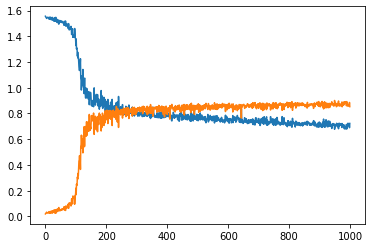

In [ ]:
plt.plot(my_model.history['loss'])
plt.plot(my_model.history['dice_coefficient_correct'])

In [ ]:
del model

In [ ]:
from tensorflow.keras.models import load_model
model_1.load_weights('/gdrive/MyDrive/nima_log/new_log_ISBI_data_3D/mozila_mohammadreza acount/Attention_Unet_3D/7/saved-model-3D-MS-250-0.8007-0.8398.hdf5')
model_2.load_weights('/gdrive/My Drive/nima_log/new_log_ISBI_data_3D/chrome_mahmoodian acount/Attention_Unet_3D/7/saved-model-3D-MS-250-0.8054-0.8175.hdf5')


In [ ]:
###for testing on ISBI test dataset in 3D models part 1
hf_x = h5py.File('/gdrive/My Drive/data_test_3D_ISBI_61sample.hdf5', 'r')
data_len = hf_x['data_test_3D_ISBI_61sample.hdf5'].shape[0]
print(data_len)
num_test=61

61


In [ ]:
###for testing on ISBI test dataset in 3D models part 2(AttUnet version 192)
##################
Test_FLAIR= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*flair_pp.nii')
Test_FLAIR.sort()
list_name=[]
for i,name in enumerate(Test_FLAIR):
    _,x=name.rsplit('preprocessed/',1)
    y,_,_=x.rsplit('_',2)
    z=y+'_JHU.nii'
    list_name.append(z)
##################
def zero_padding_3d(volume,size=((29, 30),(11,12),(29,30))):
    x= np.pad(volume,pad_width=size,mode='constant', constant_values=0)
    return x
#################
for i in range(num_test):
    norm_input=[]
    for j in range(0,4):
        padding=zero_padding_3d(hf_x['data_test_3D_ISBI_61sample.hdf5'][i,:,:,:,j],size=((5, 6),(0,0),(5,6)))
        padding=padding[:,12:-13,:]
        norm_test= itensity_normalize_one_volume(padding)
        norm_input.append(norm_test)
    norm_input= np.einsum('CDHW->HWDC',norm_input)
    expanded= np.expand_dims(norm_input, axis=0)
    pred_1= model_1.predict(expanded)
    pred_2= model_2.predict(expanded)
    pred_1[pred_1>=0.8]= 1
    pred_1[pred_1<0.8]= 0
    pred_2[pred_2>=0.8]= 1
    pred_2[pred_2<0.8]= 0
    pred_final =pred_1 + pred_2
    pred_final[pred_final<=1.5]=0
    pred_final[pred_final>0.5]= 1
    pred_final= np.squeeze(pred_final)
    final_mask= np.einsum('HWD->DHW',pred_final)
    final_mask= final_mask[5:-6,:,5:-6]
    final_mask= zero_padding_3d(final_mask, size=((0,0),(12,13),(0,0)))
    final_mask= np.einsum('DHW->WHD',final_mask)
    loaded_img= nib.load(Test_FLAIR[i])
    img = nib.Nifti1Image(final_mask,affine=loaded_img.affine,header=loaded_img.header,extra=loaded_img.extra,file_map=loaded_img.file_map)
    img.to_filename(os.path.join('/gdrive/My Drive/test_Attunet_for_ISBI_site',list_name[i]))


In [ ]:
###for testing on ISBI test dataset in 3D models part 2
##################
Test_FLAIR= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*flair_pp.nii')
Test_FLAIR.sort()
list_name=[]
for i,name in enumerate(Test_FLAIR):
    _,x=name.rsplit('preprocessed/',1)
    y,_,_=x.rsplit('_',2)
    z=y+'_JHU.nii'
    list_name.append(z)
##################
def zero_padding_3d(volume,size=((29, 30),(11,12),(29,30))):
    x= np.pad(volume,pad_width=size,mode='constant', constant_values=0)
    return x
#################
for i in range(num_test):
    norm_input=[]
    for j in range(0,4):
        padding=zero_padding_3d(hf_x['data_test_3D_ISBI_61sample.hdf5'][i,:,:,:,j],size=((37, 38),(19,20),(37,38)))
        norm_test= itensity_normalize_one_volume(padding)
        norm_input.append(norm_test)
    norm_input= np.einsum('CDHW->HWDC',norm_input)
    expanded= np.expand_dims(norm_input, axis=0)
    pred_1= model_1.predict(expanded)
    pred_2= model_2.predict(expanded)
    pred_1[pred_1>0.5]= 1
    pred_1[pred_1<=0.5]= 0
    pred_2[pred_2>0.5]= 1
    pred_2[pred_2<=0.5]= 0
    pred_final =pred_1 + pred_2
    pred_final[pred_final<=1]=0
    pred_final[pred_final>1]= 1
    final_mask= np.squeeze(pred_final)
    final_mask= np.einsum('HWD->DHW',final_mask)
    final_mask= final_mask[37:-38,19:-20,37:-38]
    final_mask= np.einsum('DHW->WHD',final_mask)
    loaded_img= nib.load(Test_FLAIR[i])
    img = nib.Nifti1Image(final_mask,affine=loaded_img.affine,header=loaded_img.header,extra=loaded_img.extra,file_map=loaded_img.file_map)
    img.to_filename(os.path.join('/gdrive/My Drive/test_unet_for_ISBI_site',list_name[i]))

In [ ]:
###for testing on ISBI test dataset in 3D models part 2(Unet 256 version)
##################
Test_FLAIR= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*flair_pp.nii')
Test_FLAIR.sort()
list_name=[]
for i,name in enumerate(Test_FLAIR):
    _,x=name.rsplit('preprocessed/',1)
    y,_,_=x.rsplit('_',2)
    z=y+'_JHU.nii'
    list_name.append(z)
##################
def zero_padding_3d(volume,size=((29, 30),(11,12),(29,30))):
    x= np.pad(volume,pad_width=size,mode='constant', constant_values=0)
    return x
#################
for i in range(num_test):
    norm_input=[]
    for j in range(0,4):
        padding=zero_padding_3d(hf_x['data_test_3D_ISBI_61sample.hdf5'][i,:,:,:,j],size=((37, 38),(19,20),(37,38)))
        norm_test= itensity_normalize_one_volume(padding)
        norm_input.append(norm_test)
    norm_input= np.einsum('CDHW->HWDC',norm_input)
    expanded= np.expand_dims(norm_input, axis=0)
    pred_1= model_1.predict(expanded)
    pred_2= model_2.predict(expanded)
    pred_1[pred_1>=0.8]= 1
    pred_1[pred_1<0.8]= 0
    pred_2[pred_2>=0.8]= 1
    pred_2[pred_2<0.8]= 0
    pred_final =pred_1 + pred_2
    norm_input=[]
    expanded=[]
    pred_1=[]
    pred_2=[]
    pred_final[pred_final<=1.5]=0
    pred_final[pred_final>0.5]= 1
    final_mask= np.squeeze(pred_final)
    pred_final=[]
    final_mask= np.einsum('HWD->DHW',final_mask)
    final_mask= final_mask[37:-38,19:-20,37:-38]
    final_mask= np.einsum('DHW->WHD',final_mask)
    loaded_img= nib.load(Test_FLAIR[i])
    img = nib.Nifti1Image(final_mask,affine=loaded_img.affine,header=loaded_img.header,extra=loaded_img.extra,file_map=loaded_img.file_map)
    img.to_filename(os.path.join('/gdrive/My Drive/test_unet_for_ISBI_site',list_name[i]))

In [ ]:
###for testing on ISBI test dataset in 3D models part 2(nestedUnet version 192)
##################
Test_FLAIR= glob.glob('/gdrive/My Drive/main dataset ISBI 2015/testdata_website/testdata_website/*/preprocessed/*flair_pp.nii')
Test_FLAIR.sort()
list_name=[]
for i,name in enumerate(Test_FLAIR):
    _,x=name.rsplit('preprocessed/',1)
    y,_,_=x.rsplit('_',2)
    z=y+'_JHU.nii'
    list_name.append(z)
##################
def zero_padding_3d(volume,size=((29, 30),(11,12),(29,30))):
    x= np.pad(volume,pad_width=size,mode='constant', constant_values=0)
    return x
#################
for i in range(num_test):
    norm_input=[]
    for j in range(0,4):
        padding=zero_padding_3d(hf_x['data_test_3D_ISBI_61sample.hdf5'][i,:,:,:,j],size=((5, 6),(0,0),(5,6)))
        padding=padding[:,12:-13,:]
        norm_test= itensity_normalize_one_volume(padding)
        norm_input.append(norm_test)
    norm_input= np.einsum('CDHW->HWDC',norm_input)
    expanded= np.expand_dims(norm_input, axis=0)
    pred_1= model_1.predict(expanded)
    pred_2= model_2.predict(expanded)
    pred_1[pred_1>=0.8]= 1
    pred_1[pred_1<0.8]= 0
    pred_2[pred_2>=0.8]= 1
    pred_2[pred_2<0.8]= 0
    pred_final =pred_1 + pred_2
    norm_input=[]
    expanded=[]
    pred_1=[]
    pred_2=[]
    pred_final[pred_final<=1.5]=0
    pred_final[pred_final>0.5]= 1
    final_mask= np.squeeze(pred_final)
    pred_final=[]
    final_mask= np.einsum('HWD->DHW',final_mask)
    final_mask= final_mask[5:-6,:,5:-6]
    final_mask= zero_padding_3d(final_mask, size=((0,0),(12,13),(0,0)))
    final_mask= np.einsum('DHW->WHD',final_mask)
    loaded_img= nib.load(Test_FLAIR[i])
    img = nib.Nifti1Image(final_mask,affine=loaded_img.affine,header=loaded_img.header,extra=loaded_img.extra,file_map=loaded_img.file_map)
    img.to_filename(os.path.join('/gdrive/My Drive/test_Nestunet_for_ISBI_site',list_name[i]))

In [ ]:
# K.set_learning_phase(0)
model.evaluate_generator(valset_generator(1),steps=279,verbose=1)

In [ ]:
# K.set_learning_phase(0)
model.evaluate_generator(valset_generator(9),steps=31,verbose=1)

In [ ]:
def check_preds(ypred, ytrue):
    smooth = np.finfo(float).eps
    pred = np.ndarray.flatten(np.clip(ypred,0,1))
    gt = np.ndarray.flatten(np.clip(ytrue,0,1))
    intersection = np.sum(pred * gt) 
    union = np.sum(pred) + np.sum(gt)   
    return np.round((2 * intersection + smooth)/(union + smooth),decimals=5)
def auc(y_true, y_pred):
    smooth = 0.0000001
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + smooth) / (tp + fn + smooth)  #recall(sensitivity)
    tnr = (tn + smooth) / (tn + fp + smooth)  #specificity
    prec = (tp + smooth) / (tp + fp + smooth) #precision
    fpr = (fp + smooth) / (fp + tn + smooth)
    return [tpr, tnr, prec, fpr]

In [ ]:
################################################################################
###for validation
hf_x_val = h5py.File('/gdrive/My Drive/data_val_ISBI_just_ms_slice.hdf5', 'r')
hf_y_val = h5py.File('/gdrive/My Drive/label_val_ISBI_just_ms_slice.hdf5', 'r')
hf_x_train = h5py.File('/gdrive/My Drive/data_train_ISBI_just_ms_slice.hdf5', 'r')
hf_y_train = h5py.File('/gdrive/My Drive/label_train_ISBI_just_ms_slice.hdf5', 'r')
print(np.shape(hf_x_val['data_val_ISBI_just_ms_slice'][0,:,:,:]))
print(np.shape(hf_y_val['label_val_ISBI_just_ms_slice'][0,:,:,:]))
print(np.shape(hf_x_train['data_train_ISBI_just_ms_slice'][0,:,:,:]))
print(np.shape(hf_y_train['label_train_ISBI_just_ms_slice'][0,:,:,:]))
num_val=279
dsc = np.zeros((num_val,1))
preds = np.zeros((num_val,240,240,1))
gt = np.zeros((num_val,240,240,1))
tpr = np.zeros_like(dsc)
tn = np.zeros_like(dsc)
prec = np.zeros_like(dsc)
tnr = np.zeros_like(dsc)
fpr = np.zeros_like(dsc)